# Deep Learning : GNN for classification of companies
# Notebook of Lucas Rakotoarivony

# 0) Importation of useful libraries

In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import torch.nn as nn

# 1) Extraction and visualization of the data

In [2]:
data_train = pd.read_excel("Training_Data.01.xlsx").dropna()
data_test = pd.read_excel("Testing_Data_2_.xlsx")

We extract the data from the dataset by deleting the lines where information is missing (rarely the case so this is not a problem).

In [3]:
type_of_companies = set(data_train['Industry Classification Tag'])
stop = stopwords.words('english')
stop.append("the")
stop.append("company")
stop_words=set(stop)
label_company = dict()
label_other = dict()
index = 0
for s in type_of_companies:
    label_company[index]=s
    label_other[s]=index
    index+=1

Each type of company is defined by a number and stored in a dictionary. This will be more useful when learning.  
We then define a list of words that are common in the English language and therefore would not be relevant to consider.

Now we want to see if for each sector of activity there are words that are frequent in their description.  
We will therefore count the most common words for each sector and visualize them using a curve.  
We choose to focus on the 10 most important words each time to have a sufficient sample, but this choice is arbitrary.

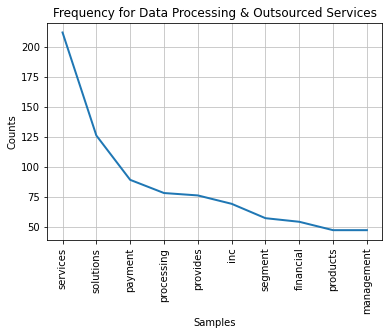

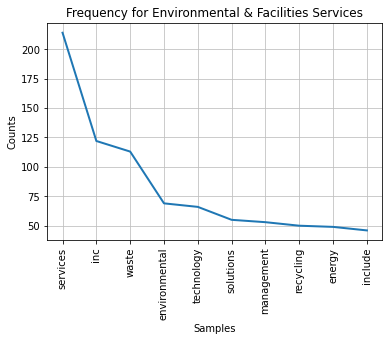

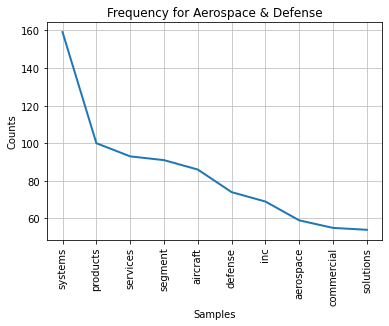

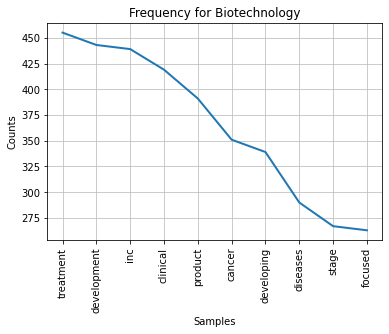

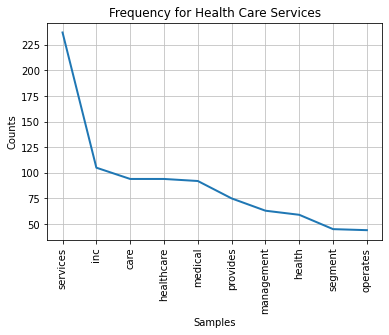

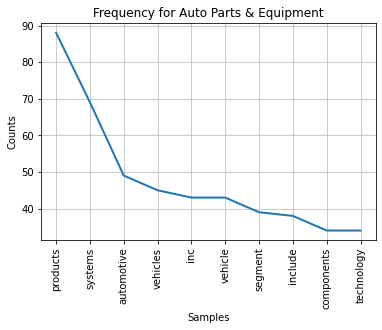

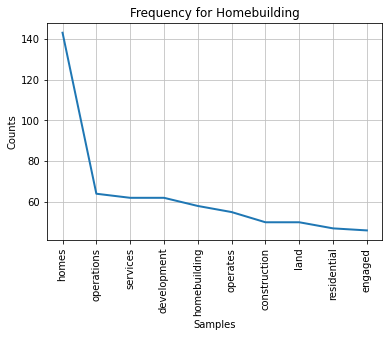

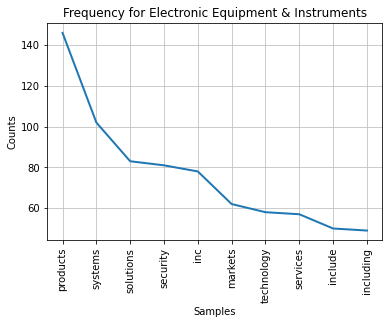

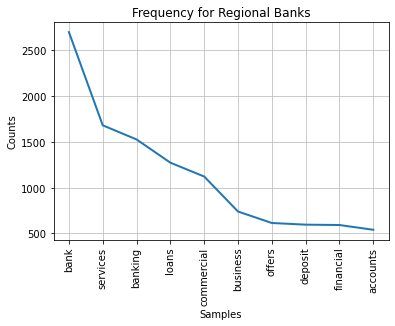

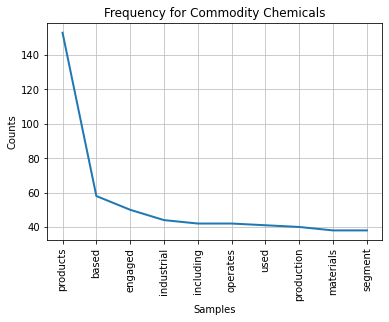

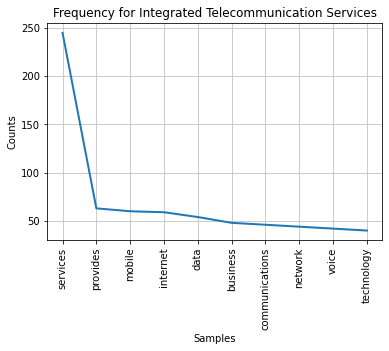

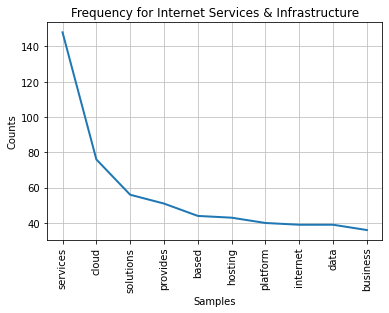

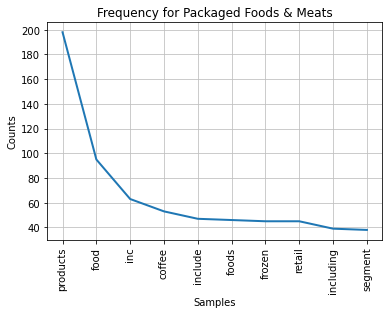

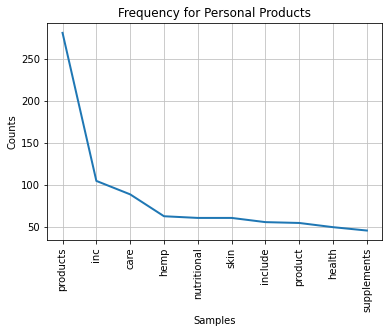

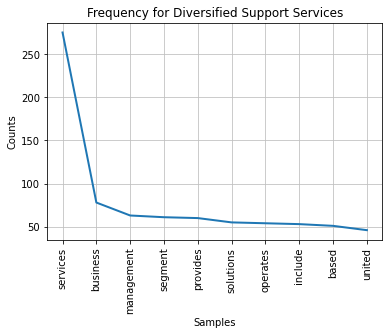

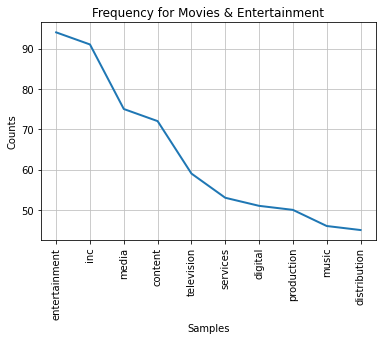

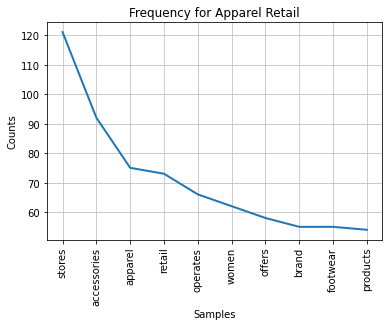

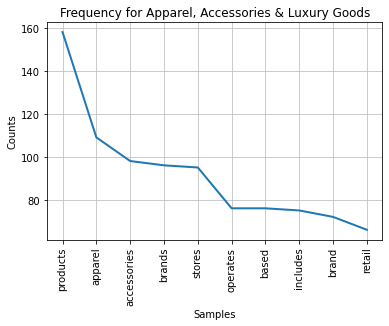

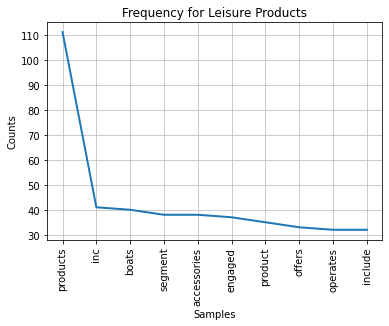

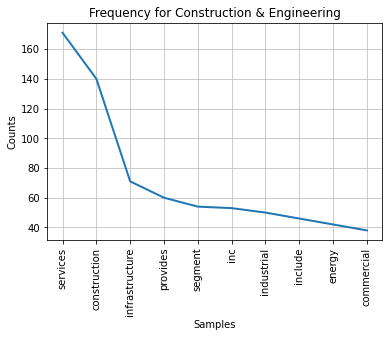

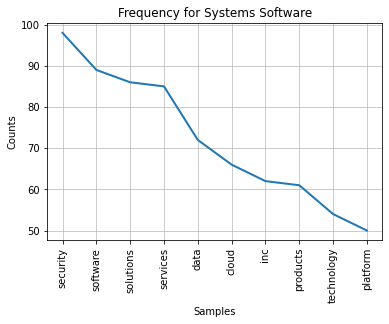

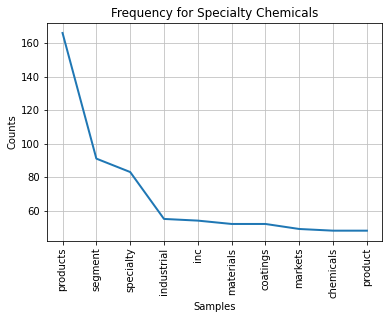

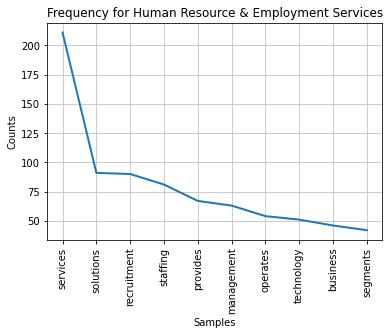

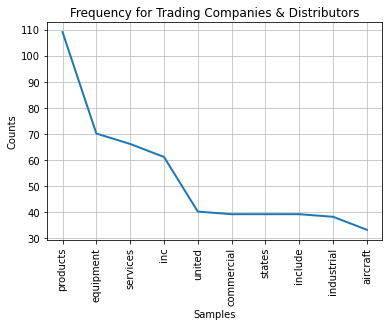

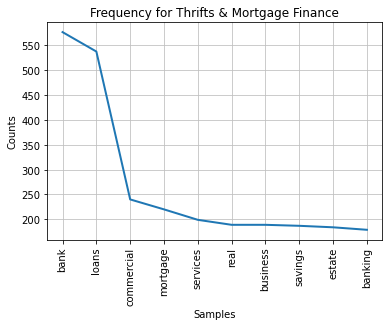

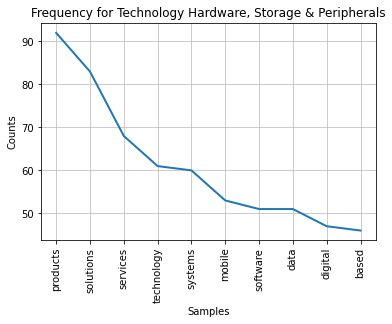

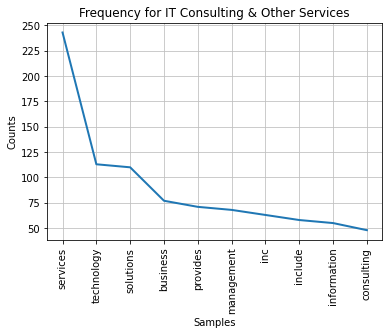

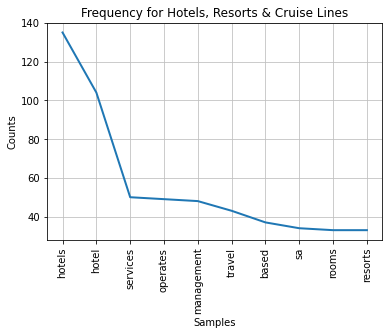

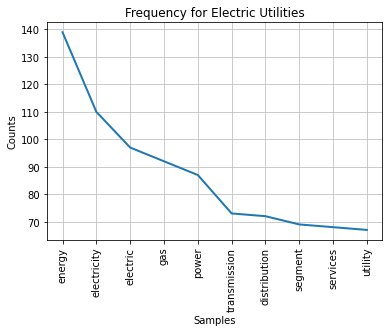

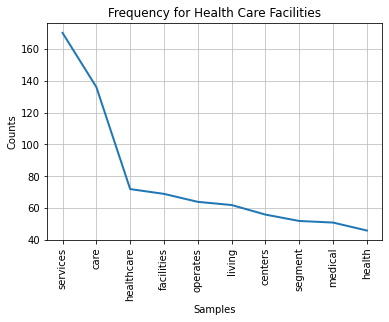

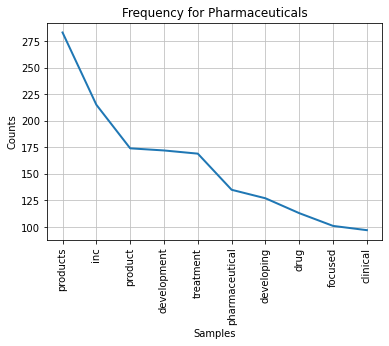

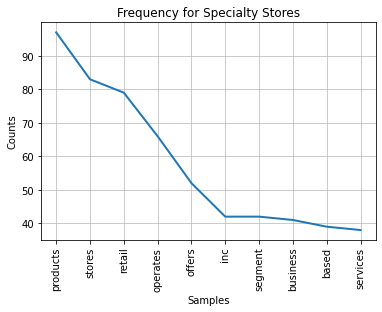

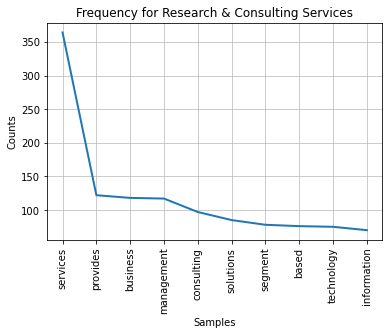

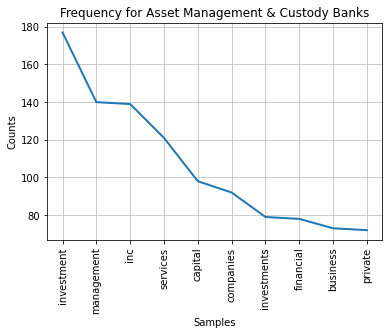

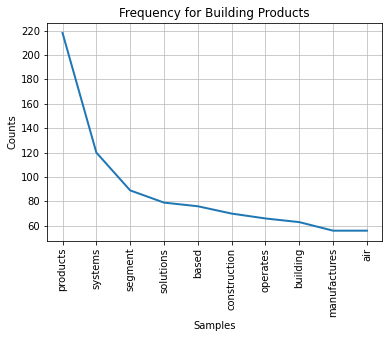

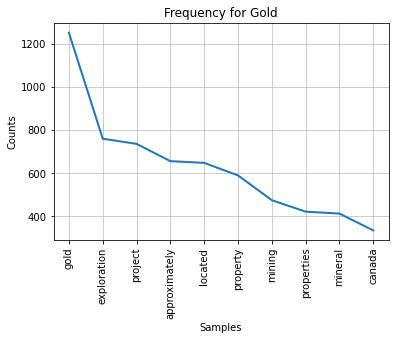

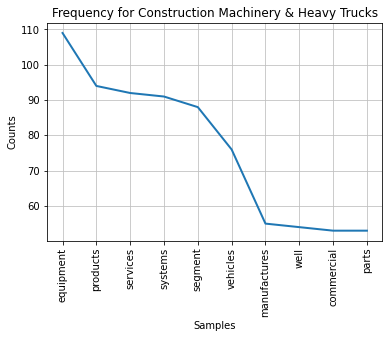

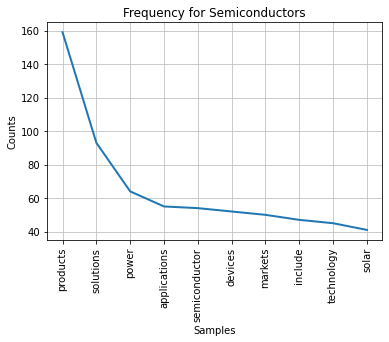

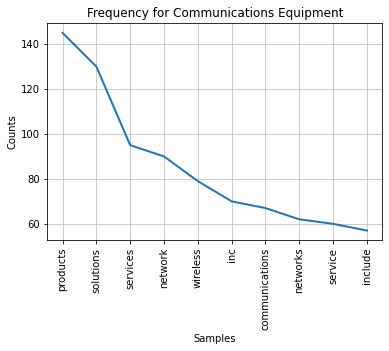

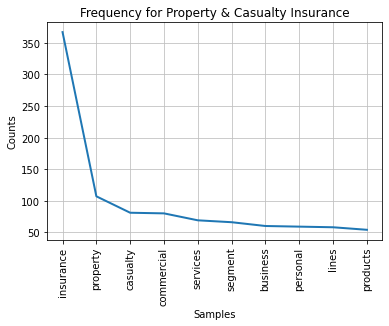

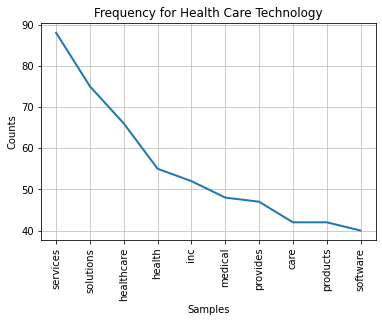

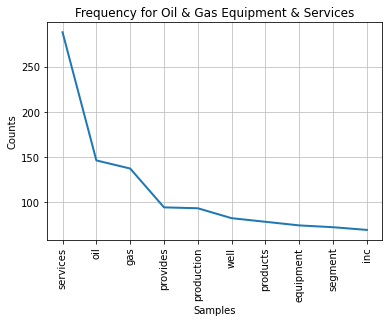

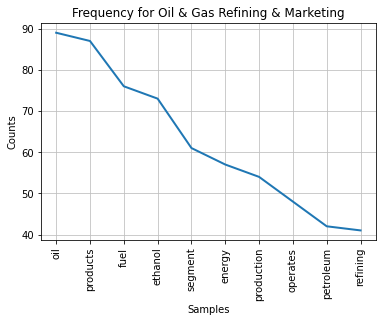

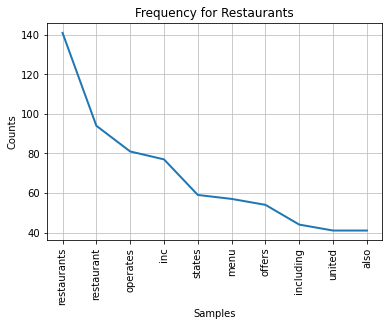

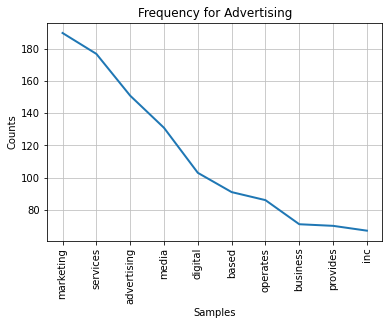

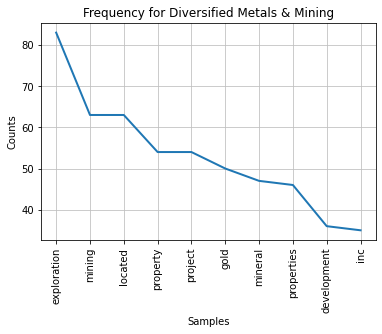

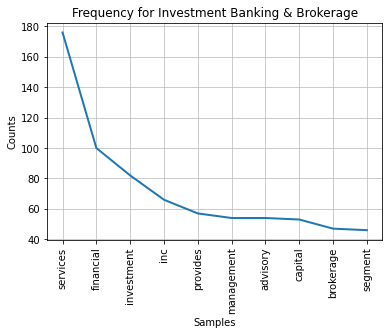

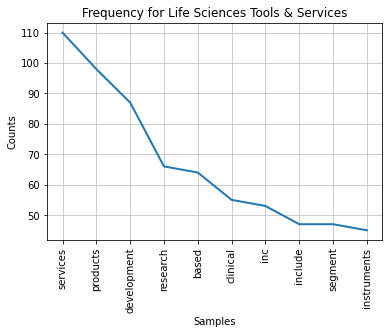

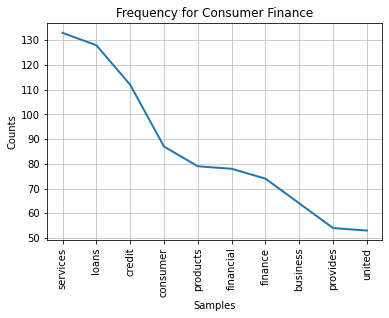

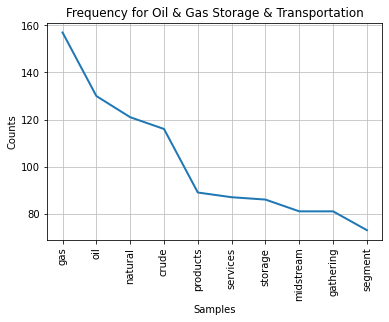

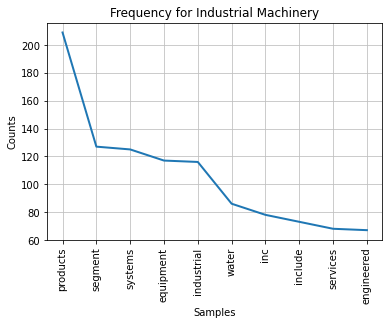

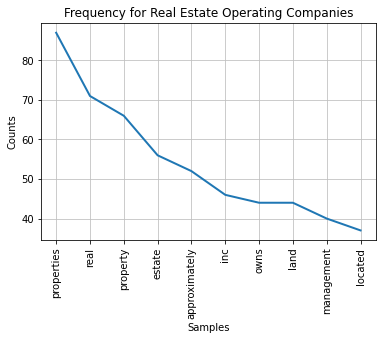

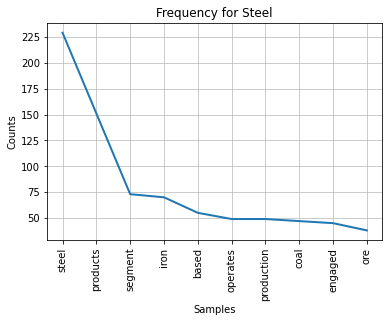

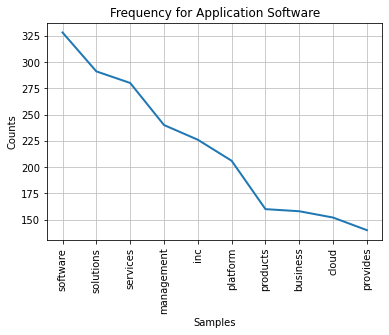

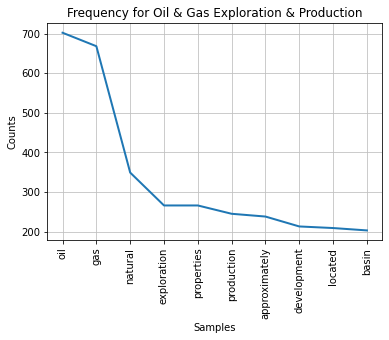

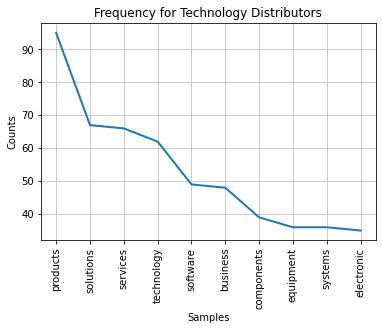

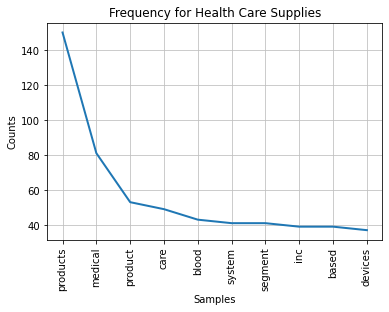

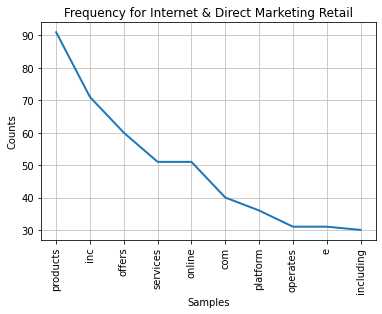

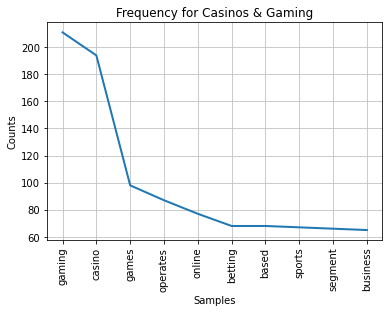

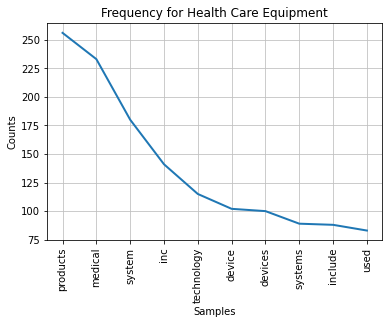

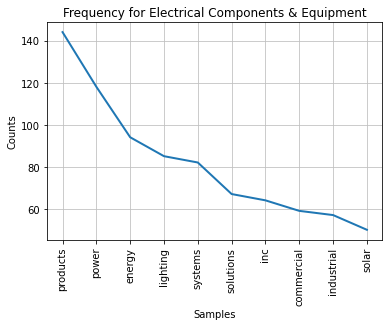

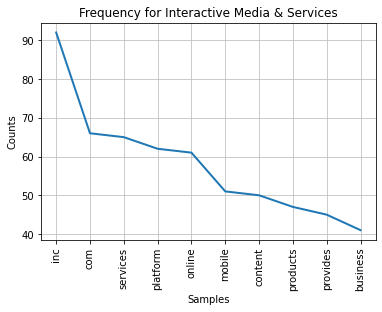

In [4]:
for s in type_of_companies:
    df=data_train[data_train['Industry Classification Tag'] == s]
    description=''
    for i in df.index: 
        description+=df["Business Description"][i]
    tokenizer = RegexpTokenizer(r'\w+')
    filtered_sentence=[]
    word_tokens = tokenizer.tokenize(description)
    for w in word_tokens:
        if w.lower() not in stop_words:
            filtered_sentence.append(w.lower())

    fdist2 = FreqDist(filtered_sentence)
    fdist2.plot(10,cumulative=False,title='Frequency for '+str(s))

Looking at the key words of each sector (the words most commonly used in the description), we find words that represent the sector of activity (online for Internet & Direct Marketing Retail).  
So we can work and design our GNN by focusing on those words.

# 2) Preprocessing of the data

In [5]:
def load_data(data):
    '''Extract the data from the dataframe'''
    x_raw = data['Business Description'].values
    y = data['Industry Classification Tag'].values
    return x_raw,y

In [6]:
def clean_text(x_raw):
    '''Clean the data by deleting symbole and number'''
    x_raw = [x.lower() for x in x_raw]
    x_raw = [re.sub(r'[^A-Za-z]+', ' ', x) for x in x_raw]
    return x_raw

Numbers and symbols are not considered to add any information to the type of business. Indeed symbols are often punctuation and numbers may be present in all sectors.

In [7]:
def text_tokenization(x_raw):
    '''Tokenizes each sentence by implementing the nltk tool'''
    x_raw = [word_tokenize(x) for x in x_raw]
    return x_raw

It is necessary to tokenizer the descriptions before using nltk otherwise the library considers each letter to be a separate word

In [8]:
def build_vocabulary(x_raw,numwords):
    '''Builds the vocabulary which is a dictionnary and keeps the "numwords" most frequent words'''
    vocabulary = dict()
    fdist = nltk.FreqDist() 
    for sentence in x_raw:
        for word in sentence:
            if word not in stop_words:
                fdist[word] += 1

    common_words = fdist.most_common(numwords)

    for idx, word in enumerate(common_words):
        vocabulary[word[0]] = (idx)
    return vocabulary

From all the descriptions we extract the most common words because we consider them to be the most important. Common words are also avoided.

In [9]:
def word_to_idx(vocabulary,x_raw):
    '''For each description we count for each word in the vocabulary how many times this word has been used.'''
    x_tokenized = list()
    for sentence in x_raw:
        temp_sentence = len(vocabulary) * [0]
        for word in sentence:
            if word in vocabulary.keys():
                temp_sentence[vocabulary[word]]+=1
        x_tokenized.append(temp_sentence)
    x_tokenized = np.array(x_tokenized)
    return x_tokenized

We thus obtain an array of numwords size and the value at index i represents the number of times that the word of the vocabulary at index i was used

In [69]:
numwords=60

x_raw , y =load_data(data_train)
x_raw = clean_text(x_raw)
x_raw = text_tokenization(x_raw)
vocabulary = build_vocabulary(x_raw,numwords)
x_tokenized = word_to_idx(vocabulary,x_raw)

y_label=[]
for lab in y:
    y_label.append(label_other[lab])
    
x_train, x_valid, y_train, y_valid = train_test_split(x_tokenized, y_label, test_size=0.2)

We choose numwords equal to 60 because this allows us to have a sample of words sufficient to characterize each sector of activity.  
Each description was replaced by an array representing the number of times each word was used and the business line by a number.

In [11]:
class DatasetMaper(Dataset):
    '''class that allow us to build the dataset for training and validation'''

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [70]:
batch_size=100
train = DatasetMaper(x_train, y_train)
valid = DatasetMaper(x_valid, y_valid)

# Initialize loaders
train_loader = DataLoader(train, batch_size=batch_size)
validation_loader = DataLoader(valid, batch_size=batch_size)

We just define our dataloader with a batch size of 100. We choose 100 because it was a batch size that give good results.

# 3) Construction of the GNN and training

In [13]:
class EdgeConv(MessagePassing):
    '''My Edge convolutionnal layer who allow us to use GNN'''
    def __init__(self, F_in, F_out):
        super(EdgeConv, self).__init__(aggr='max')
        self.mlp = Seq(Lin(2 * F_in, F_out), ReLU(), Lin(F_out, F_out))

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        edge_features = torch.cat([x_i, x_j - x_i], dim=1)
        return self.mlp(edge_features)

I'm aware that my edge convolutionnal layer is quite simple (in fact it is an example of the library PyTorch Geometric). However, since I never had the opportunity to work on a GNN before, I preferred to use a layer that was simple but efficient and concentrate on carrying out all the tasks required.  
I would have liked to work in more detail on a more developed GNN but I did not have the opportunity because of lack of time.

In [112]:
class GNN(torch.nn.Module):
    '''The class who build my GNN'''
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = EdgeConv(numwords, 16)
        self.conv2 = EdgeConv(16, len(type_of_companies))

    def forward(self, x):
        '''The classic forward method with the edge convolutionnal layer, dropout, relu and Softmax for the probabilities'''
        edge_index=np.zeros((0,0))
        number_edge=0
        for i in range(len(x)):
            for j in range(i+1,len(x)):
                for index in range(len(x[i])):
                    if(x_tokenized[i][index] in x_tokenized[j] and x_tokenized[i][index]!=0):
                        edge_index = np.append(edge_index, [i,j])
                        edge_index = np.append(edge_index, [j,i])
                        number_edge+=1
                        break;
        edge = torch.from_numpy(edge_index).reshape((number_edge*2,2)).long()
        edge = edge.t().contiguous()
        x = self.conv1(x, edge)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge)

        return F.softmax(x, dim=1)
    
    def forward_label(self, x):
        '''This method return a list of the five more probable sector of activities'''
        edge_index=np.zeros((0,0))
        number_edge=0
        for i in range(len(x)):
            for j in range(i+1,len(x)):
                for index in range(len(x_tokenized[i])):
                    if(x_tokenized[i][index] in x_tokenized[j] and x_tokenized[i][index]!=0):
                        edge_index = np.append(edge_index, [i,j])
                        edge_index = np.append(edge_index, [j,i])
                        number_edge+=1
                        break;
        edge = torch.from_numpy(edge_index).reshape((number_edge*2,2)).long()
        edge = edge.t().contiguous()
        x = self.conv1(x, edge)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge)
        x = F.softmax(x, dim=1)
        idx = torch.topk(x, k=5, dim=1)[1]
        lab = []
        for  i in idx[0]:
            lab.append(label_company[i.item()])
        return lab

As before my GNN is quite simple. This is for the same reasons as before, and I think it can be a point of improvement for my work.  
I chose to link two companies together with a link if they have a common word repeated the same number of times. This method gives me better results than by linking companies that use the same word at least once.  
This method is obviously not a reference we could for example link companies if they have k words or more in common in their description.

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [114]:
GNN_model = GNN()
GNN_model.to(device=device)

GNN(
  (conv1): EdgeConv(
    (mlp): Sequential(
      (0): Linear(in_features=120, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (conv2): EdgeConv(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=62, bias=True)
      (1): ReLU()
      (2): Linear(in_features=62, out_features=62, bias=True)
    )
  )
)

In [115]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GNN_model.parameters(),lr = 0.001)

We use the CrossEntropy because it is the standard loss for multiclassication task.  
And we use the optimizer Adam because it is an efficient optimizer. The learning rate is choose because we have good results with that value.

In [98]:
n_epochs = 30 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):
    '''Method who train the GNN for n_epochs, return the different loss so we can plot it'''
    train_losses, valid_losses = [], []
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial "min" to infinity

    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0 # monitor losses

        # train the model
        model.train() # prep model for training
        for data, label in train_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(output, label) # calculate the loss
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item() * data.size(0) # update running training loss

        # validate the model
        model.eval()
        for data, label in valid_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            with torch.no_grad():
                output = model(data)
            loss = criterion(output,label)
            valid_loss += loss.item() * data.size(0)

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss

    return train_losses, valid_losses

In [120]:
train_losses, valid_losses = training(n_epochs, train_loader, validation_loader, GNN_model, criterion, optimizer)

epoch: 1 	training Loss: 4.114599 	validation Loss: 4.062551
validation loss decreased (inf --> 4.062551).  Saving model ...
epoch: 2 	training Loss: 4.017471 	validation Loss: 3.968847
validation loss decreased (4.062551 --> 3.968847).  Saving model ...
epoch: 3 	training Loss: 3.976976 	validation Loss: 3.921132
validation loss decreased (3.968847 --> 3.921132).  Saving model ...
epoch: 4 	training Loss: 3.948403 	validation Loss: 3.907190
validation loss decreased (3.921132 --> 3.907190).  Saving model ...
epoch: 5 	training Loss: 3.935122 	validation Loss: 3.900421
validation loss decreased (3.907190 --> 3.900421).  Saving model ...
epoch: 6 	training Loss: 3.930156 	validation Loss: 3.898388
validation loss decreased (3.900421 --> 3.898388).  Saving model ...
epoch: 7 	training Loss: 3.926415 	validation Loss: 3.897980
validation loss decreased (3.898388 --> 3.897980).  Saving model ...
epoch: 8 	training Loss: 3.921940 	validation Loss: 3.897056
validation loss decreased (3.89798

# 4) Evaluation of the GNN

In [39]:
def MRR(train_loader, valid_loader, model):
    '''Function that return the MRR (Mean Reciprocal Rank) score for the train and validation set'''
    model.train()
    mrr_train=0
    index_train=0
    for data, label in train_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        optimizer.zero_grad() 
        output = model(data)
        for i in range(len(label)):
            idx = torch.topk(output[i], k=5, dim=0)[1]
            if(label[i] in idx):
                ind = (idx == label[i]).nonzero().item()
                mrr_train+=1/(1+ind)
        index_train+=len(label)
    mrr_train=mrr_train/index_train


    model.eval()
    mrr_valid=0
    index_valid=0
    for data, label in valid_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        for i in range(len(label)):
            idx = torch.topk(output[i], k=5, dim=0)[1]
            if(label[i] in idx):
                ind = (idx == label[i]).nonzero().item()
                mrr_valid+=1/(1+ind)
        index_valid+=len(label)
    mrr_valid=mrr_valid/index_valid
    return  mrr_train,mrr_valid


In [40]:
def F1_score(train_loader, valid_loader, model):
    '''Function that return the  F1-score for the train and validation set'''
    model.train()
    y_train_pred = []
    y_train_true = []
    for data, label in train_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        output = model(data)
        for i in range(len(label)):
            y_train_pred.append(torch.argmax(output[i]).item())
            y_train_true.append(label[i].item())
        


    model.eval()
    y_valid_pred = []
    y_valid_true = []
    for data, label in valid_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        for i in range(len(label)):
            y_valid_pred.append(torch.argmax(output[i]).item())
            y_valid_true.append(label[i].item())
    return  f1_score(y_train_true, y_train_pred, average='micro'), f1_score(y_valid_true, y_valid_pred, average='micro')


In [41]:
def AUC_score(train_loader, valid_loader, model):
    '''Function that return the AUC score for the train and validation set'''
    model.train()
    y_train_true = []
    index=0
    for data, label in train_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        optimizer.zero_grad() 
        output = model(data)
        if(index==0):
            y_train_pred = output.detach().numpy()
        else:  
            y_train_pred = np.vstack([y_train_pred, output.detach().numpy()])
        index+=1
        for i in range(len(label)):
            y_train_true.append(label[i].item())
        


    model.eval()
    y_valid_pred = np.empty(0)
    y_valid_true = []
    index = 0
    for data, label in valid_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        if(index==0):
            y_valid_pred = output.detach().numpy()
        else:  
            y_valid_pred = np.vstack([y_valid_pred, output.detach().numpy()])
        index+=1
        for i in range(len(label)):
            y_valid_true.append(label[i].item())
    return  roc_auc_score(y_train_true, y_train_pred,multi_class='ovr'), roc_auc_score(y_valid_true, y_valid_pred,multi_class='ovr')


In [121]:
mrr_train,mrr_valid = MRR(train_loader, validation_loader, GNN_model)
f1_train,f1_valid = F1_score(train_loader, validation_loader, GNN_model)
Auc_train,Auc_valid = AUC_score(train_loader, validation_loader, GNN_model)

In [122]:
print(f'Value of the MRR score for the train set: {mrr_train:.2f} Value of the MRR score for the validation set {mrr_valid:.2f}.')
print(f'Value of the F1 score for the train set: {f1_train:.2f} Value of the F1 score for the validation set {f1_valid:.2f}.')
print(f'Value of the AUC score for the train set: {Auc_train:.2f} Value of the AUC score for the validation set {Auc_valid:.2f}.')

Value of the MRR score for the train set: 0.29 Value of the MRR score for the validation set 0.30.
Value of the F1 score for the train set: 0.27 Value of the F1 score for the validation set 0.29.
Value of the AUC score for the train set: 0.61 Value of the AUC score for the validation set 0.62.


We see directly that the F1-score and MRR are not high but remain correct. This can be explained in particular by the number of relatively small periods that we used because the algorithm is very slow. Moreover, the number of words chosen is quite small because the increase of this variable slows down the algorithm.  
Moreover we build the graph only on the elements of the batch so the graph is a sub graph so it decreases the results.  
This makes it easy to imagine significantly increasing the results by modifying the architecture of my GNN and modifying certain parameters. I would have liked to make these changes myself, but I couldn’t because of time constraints.

In [123]:
sub_data_test = data_test.sample(frac=0.25)
name = sub_data_test['Company '].values
x_raw_test = sub_data_test['Business Description'].values
x_raw_test = clean_text(x_raw_test)
x_raw_test = text_tokenization(x_raw_test)
x_tokenized_test = word_to_idx(vocabulary,x_raw_test)

In [127]:
for i in range(len(x_tokenized_test)):
    sector = GNN_model.forward_label(torch.from_numpy(x_tokenized_test[i]).reshape(1,numwords).float())
    print(f'Name of the company: {name[i]} . Five most probable sector of activities {sector}')
    print()

Name of the company: Alankit Ltd . Five most probable sector of activities ['Data Processing & Outsourced Services', 'Environmental & Facilities Services', 'Aerospace & Defense', 'Biotechnology', 'Health Care Services']


Name of the company: Janus Corporation Ltd . Five most probable sector of activities ['Data Processing & Outsourced Services', 'Environmental & Facilities Services', 'Aerospace & Defense', 'Biotechnology', 'Health Care Services']


Name of the company: Deepak Nitrite Ltd. . Five most probable sector of activities ['Data Processing & Outsourced Services', 'Environmental & Facilities Services', 'Aerospace & Defense', 'Biotechnology', 'Health Care Services']


Name of the company: Franklin Leasing and Finance Ltd . Five most probable sector of activities ['Data Processing & Outsourced Services', 'Environmental & Facilities Services', 'Aerospace & Defense', 'Biotechnology', 'Health Care Services']


Name of the company: Ircon International Ltd . Five most probable sector 

I think I have a mistake in this part because the types of companies are always the same. However, I did not have time to find this error on my own.

# Conclusion

Looking only at the results of my GNN one can be disappointed because the results are not excellent. However there are still many things that are easily improved that I did not have time to do for lack of time.  
However, I am proud of my work because I had never worked on NGNs before and I had done very little Deep Learning on texts. I think I have done quality work that shows my motivation, my ability to learn and adapt to a project.  
I hope that my work will make you want to give me a chance for this internship that I am really interested in and would really like to get.